In [24]:

# %pip install wordcloud
# %pip install praw

In [25]:
shoe_brand = 'Nike'

In [26]:
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [27]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
r = praw.Reddit(client_id='GJtzNYyCMIW-66t_xry24Q',
                     client_secret='ClyB_Id7qbhShlg4P43xqrLiyXPvyA',
                     user_agent='ljx597620034')

In [29]:
subreddit = r.subreddit(shoe_brand)

shoes_subreddit_top_posts = [*subreddit.top(limit=None)] # top posts all time

print(len(shoes_subreddit_top_posts))

999


In [30]:
shoes0 = shoes_subreddit_top_posts[0]

# pprint(vars(news0)) 
print(shoes0.title) # headline
print(shoes0.score) # upvotes
print(shoes0.created) # UNIX timestamps 
print(dt.datetime.fromtimestamp(shoes0.created)) # date and time
print(shoes0.num_comments) # no. of comments
print(shoes0.upvote_ratio) # upvote / total votes
print(shoes0.total_awards_received) # no. of awards given

Yea I was that mom that messaged Nike asking questions 😅. Thought it wouldn't hurt to spam the internet to get Nike shoes to look at accommodating kids with special needs. To date we've yet to find a shoe that actually fits with Maddy's AFOs.
1400
1612239524.0
2021-02-01 23:18:44
49
0.99
14


In [31]:
title = [i.title for i in shoes_subreddit_top_posts]
shoes = pd.DataFrame({
    "title": title,
})
shoes.head()

,title
0,Yea I was that mom that messaged Nike asking q...
1,I made this hat out of 90’s Nike tags I sewed ...
2,😶
3,Nike Logo
4,A pair of custom Charizard Nikes my dad got me...


In [32]:
sid = SentimentIntensityAnalyzer()

In [33]:
res = [*shoes['title'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': 0.764, 'neg': 0.0, 'neu': 0.841, 'pos': 0.159},
 {'compound': 0.4588, 'neg': 0.0, 'neu': 0.769, 'pos': 0.231},
 {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}]


In [34]:
sentiment_df = pd.DataFrame.from_records(res)

shoes = pd.concat([shoes, sentiment_df], axis=1, join='inner')
shoes.head()

,title,neg,neu,pos,compound
0,Yea I was that mom that messaged Nike asking q...,0.0,0.841,0.159,0.7640
1,I made this hat out of 90’s Nike tags I sewed ...,0.0,0.769,0.231,0.4588
2,😶,0.0,0.000,0.000,0.0000
3,Nike Logo,0.0,1.000,0.000,0.0000
4,A pair of custom Charizard Nikes my dad got me...,0.0,0.759,0.241,0.6597


In [35]:
THRESHOLD = 0.4

conditions = [
    (shoes['compound'] <= -THRESHOLD),
    (shoes['compound'] > -THRESHOLD) & (shoes['compound'] < THRESHOLD),
    (shoes['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
shoes['label'] = np.select(conditions, values)

shoes.head()

,title,neg,neu,pos,compound,label
0,Yea I was that mom that messaged Nike asking q...,0.0,0.841,0.159,0.7640,pos
1,I made this hat out of 90’s Nike tags I sewed ...,0.0,0.769,0.231,0.4588,pos
2,😶,0.0,0.000,0.000,0.0000,neu
3,Nike Logo,0.0,1.000,0.000,0.0000,neu
4,A pair of custom Charizard Nikes my dad got me...,0.0,0.759,0.241,0.6597,pos


In [36]:
sentence0 = shoes.title.iloc[0]
print(sentence0)
words0 = shoes.title.iloc[0].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0: 
    if (sid.polarity_scores(word)['compound']) >= THRESHOLD:
        pos_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -THRESHOLD:
        neg_list.append(word)
    else:
        neu_list.append(word)                

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sid.polarity_scores(sentence0)

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")

if score['compound'] >= THRESHOLD:
    print(f"The compound value : {score['compound']} >= {THRESHOLD}")
    print(f"\nThis sentence is positive")
elif score['compound'] <= -THRESHOLD:
    print(f"\nThis sentence is negative")
    print(f"The compound value : {score['compound']} <= {-THRESHOLD}")
else:
    print(f"\nThis sentence is neutral")
    print(f"The compound value : {-THRESHOLD}<={score['compound']<={THRESHOLD}}")

Yea I was that mom that messaged Nike asking questions 😅. Thought it wouldn't hurt to spam the internet to get Nike shoes to look at accommodating kids with special needs. To date we've yet to find a shoe that actually fits with Maddy's AFOs.
['Yea', 'I', 'was', 'that', 'mom', 'that', 'messaged', 'Nike', 'asking', 'questions', '😅.', 'Thought', 'it', "wouldn't", 'hurt', 'to', 'spam', 'the', 'internet', 'to', 'get', 'Nike', 'shoes', 'to', 'look', 'at', 'accommodating', 'kids', 'with', 'special', 'needs.', 'To', 'date', "we've", 'yet', 'to', 'find', 'a', 'shoe', 'that', 'actually', 'fits', 'with', "Maddy's", 'AFOs.']

Positive: ['special']
Neutral: ['Yea', 'I', 'was', 'that', 'mom', 'that', 'messaged', 'Nike', 'asking', 'questions', '😅.', 'Thought', 'it', "wouldn't", 'to', 'spam', 'the', 'internet', 'to', 'get', 'Nike', 'shoes', 'to', 'look', 'at', 'accommodating', 'kids', 'with', 'needs.', 'To', 'date', "we've", 'yet', 'to', 'find', 'a', 'shoe', 'that', 'actually', 'fits', 'with', "Maddy

In [37]:
shoes.label.value_counts()

neu    731
pos    240
neg     28
Name: label, dtype: int64

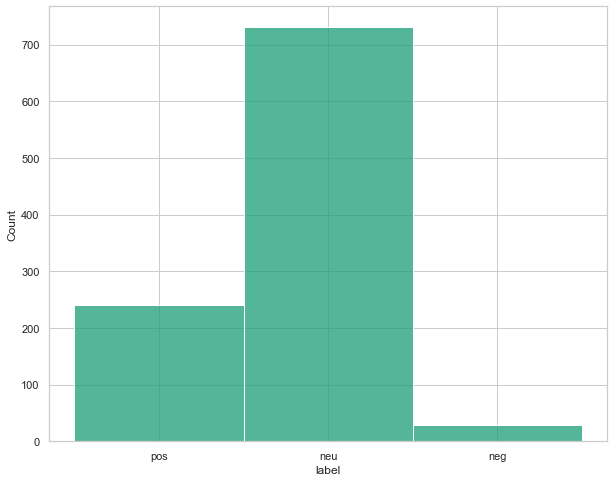

In [38]:
sns.histplot(shoes.label);

In [39]:
def shoes_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
shoes_sub = shoes.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
shoes_title_output(shoes_sub, "pos")

print("\nNeutral news")
shoes_title_output(shoes_sub, "neu")

print("\nNegative news")
shoes_title_output(shoes_sub, "neg")

Positive news
So happy to have grabbed both for retail - which colourway is your favourite?
Giannis Antetokuonmpo wrote "Thanasis thanks for sharing" on his Kobe 4s as a throwback to when he and his brother had to share a pair of Kobe 4s
My first jump from Adidas to Nike. Couldn’t be happier.
Wasn’t a huge fan of the Nike collection so I bought a Nike hoodie and made my own.
Air Jordan 1 sugar cookie made with royal icing (art inspiration found on Pinterest, can’t find the original source)

Neutral news
I Made another leather Nike Cardholder Wallet
Custom embroidered crew necks🔥
Air Max 90 Pixel Art
Blue hemps!!
Feeling these Air Max 90s? I didn't buy them yet but I'm thinking about it!

Negative news
I know these arent hype but i love me some uptempos!
Made these on Nike ID, I call them Wicked Games.
Are my Jordan’s fake ?
Real or fake? If real, im so hyped.
Why do people hate the AJ1 First Class Flight so much? Just picked up my own pair


In [40]:
stop_words = stopwords.words('english')
def custom_tokenize(text): 
  # remove single quote and dashes
    text = text.replace("'", "").replace("-", "").lower()

  # split on words only 
    tk = nltk.tokenize.RegexpTokenizer(r'\w+')  
    tokens = tk.tokenize(text)
    

  # remove stop words
    words = [w for w in tokens if not w in stop_words] 
    return words

In [41]:
def tokens_2_words(df, label):
  # subset titles based on label
    titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
    tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
    words = list(chain.from_iterable(tokens))
    return words

pos_words = tokens_2_words(shoes, 'pos')
neg_words = tokens_2_words(shoes, 'neg')

In [42]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('nike', 65),
 ('air', 30),
 ('love', 29),
 ('first', 29),
 ('made', 23),
 ('pair', 22),
 ('jordan', 20),
 ('got', 19),
 ('shoes', 18),
 ('favorite', 18),
 ('max', 18),
 ('best', 15),
 ('1', 14),
 ('happy', 14),
 ('like', 13),
 ('custom', 12),
 ('look', 11),
 ('day', 11),
 ('nice', 11),
 ('time', 11)]

In [43]:
pos_im = [str(p) for p in pos_words] 
pos_str = ",".join(pos_im) 
neg_im = [str(p) for p in neg_words] 
neg_str = ",".join(neg_im)

<function matplotlib.pyplot.show(close=None, block=None)>

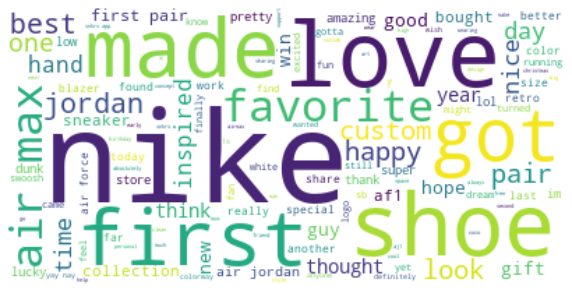

In [44]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_cloud_pos = WordCloud(background_color = "white").generate(pos_str)
word_cloud_neg = WordCloud().generate(neg_str)
plt.imshow(word_cloud_pos,interpolation = "bilinear") 
plt.axis("off") 
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

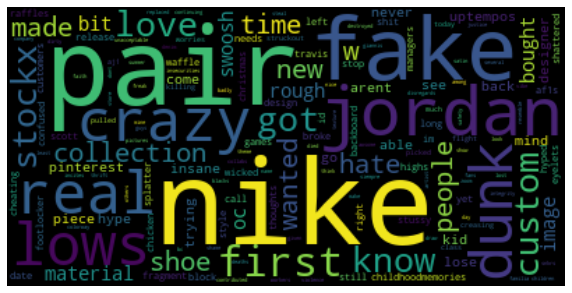

In [45]:
plt.imshow(word_cloud_neg,interpolation = "bilinear") 
plt.axis("off") 
plt.show